In [1]:
from matplotlib import pyplot as plt

import numpy as np
np.random.seed(42)
import random
random.seed(42)

# Question 1

Fetch dataset

In [2]:
from sklearn.datasets import fetch_20newsgroups

categories = ['comp.sys.ibm.pc.hardware', 'comp.graphics',
              'comp.sys.mac.hardware', 'comp.os.ms-windows.misc',
              'rec.autos', 'rec.motorcycles',
              'rec.sport.baseball', 'rec.sport.hockey']

dataset = fetch_20newsgroups(subset='all', categories=categories,
                             shuffle=True, random_state=42)

Create TF-IDF matrix

In [3]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

# count
vectorizer = CountVectorizer(min_df=3, stop_words='english')
X_counts = vectorizer.fit_transform(dataset.data)

# TF-IDF
tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X_counts)
print("Dimension of TF-IDF matrix is ",X_tfidf.shape)

('Dimension of TF-IDF matrix is ', (7882, 27768))


# Question 2

K-means directly on full-dimension data

In [87]:
from sklearn.cluster import KMeans
from sklearn import metrics

km = KMeans(n_clusters=2, random_state=0, max_iter=1000, n_init=30, init='k-means++')
km.fit(X_tfidf)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=1000,
    n_clusters=2, n_init=30, n_jobs=1, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

In [88]:
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(2):
    print("Cluster %d:" % i,)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])

Top terms per cluster:
('Cluster 0:',)
 edu
 game
 team
 ca
 games
 year
 hockey
 players
 baseball
 writes
('Cluster 1:',)
 edu
 com
 subject
 lines
 organization
 windows
 university
 posting
 host
 nntp


Overwrite original labels with bin labels

In [89]:
_, idx = np.unique(dataset.target, return_index=True)
for i in range(len(idx)):
    print(dataset.target_names[i],': target index = ', dataset.target[idx[i]])    

('comp.graphics', ': target index = ', 0)
('comp.os.ms-windows.misc', ': target index = ', 1)
('comp.sys.ibm.pc.hardware', ': target index = ', 2)
('comp.sys.mac.hardware', ': target index = ', 3)
('rec.autos', ': target index = ', 4)
('rec.motorcycles', ': target index = ', 5)
('rec.sport.baseball', ': target index = ', 6)
('rec.sport.hockey', ': target index = ', 7)


In [90]:
labels = np.zeros_like(dataset.target)
for y in [4,5,6,7]:
    labels[np.argwhere(dataset.target == y)] = 0
for y in [0,1,2,3]:
    labels[np.argwhere(dataset.target == y)] = 1    
class_names = ['Recreational Activity', 'Computer Technology']

cm = metrics.cluster.contingency_matrix(labels, km.labels_)

In [91]:
import itertools
def plot_contingency_matrix(cm, classes,
                          normalize=False,
                          title='Contingency matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the contingency matrix.
    Normalization can be applied by setting normalize=True.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum()
        print("Normalized Contingency matrix")
    else:
        print('Contingency matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Contingency matrix, without normalization
[[1718 2261]
 [   4 3899]]


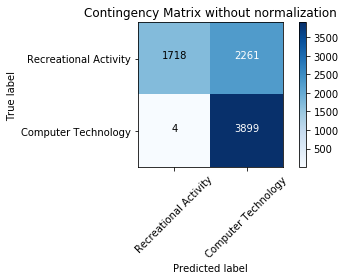

In [92]:
plt.figure()
plot_contingency_matrix(cm, classes=class_names, normalize=False,
                      title='Contingency Matrix without normalization')

plt.show()

# Question 3

In [93]:
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, km.labels_))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(labels, km.labels_))
print("adjusted_mutual_info_score: %0.3f"
      % metrics.adjusted_mutual_info_score(labels, km.labels_))

Homogeneity: 0.254
Completeness: 0.335
V-measure: 0.289
Adjusted Rand-Index: 0.181
adjusted_mutual_info_score: 0.254


# Question 4

In [94]:
from sklearn.decomposition import TruncatedSVD
import heapq

svd = TruncatedSVD(n_components=1000, random_state=42)
X_reduced = svd.fit_transform(X_tfidf)

From i=1000 to 1, choose the first i-th most significant features

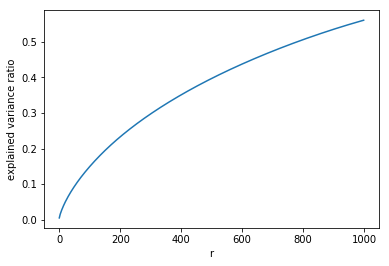

In [95]:
import heapq
evr = np.zeros(1000)
for i in range(1000,0,-1):
    evr[i-1] = np.array(heapq.nlargest(i,svd.explained_variance_ratio_)).sum()
plt.xlabel("r")
plt.ylabel("explained variance ratio")
plt.plot(evr)

# Question 5

In [96]:
r_list = [1,2,3,5,10,20,50,100,300]

homo = np.zeros(9)
comp = np.zeros(9)
vmea = np.zeros(9)
ari = np.zeros(9)
ami = np.zeros(9)

Using truncated SVD

In [ ]:
for i,r in enumerate(r_list):
    # compute X_reduced
    svd = TruncatedSVD(n_components=r, random_state=42)
    X_reduced = svd.fit_transform(X_tfidf)
    # do K-means on X_reduced
    km = KMeans(n_clusters=2, random_state=0, max_iter=1000, n_init=30, init='k-means++')
    km.fit(X_reduced)
    # evaluate using 5 measure scores
    homo[i] = metrics.homogeneity_score(labels, km.labels_)
    comp[i] = metrics.completeness_score(labels, km.labels_)
    vmea[i] = metrics.v_measure_score(labels, km.labels_)
    ari[i] = metrics.adjusted_rand_score(labels, km.labels_)
    ami[i] = metrics.adjusted_mutual_info_score(labels, km.labels_)       

In [ ]:
plt.figure();plt.plot(homo);plt.title("Homogeneity")
plt.figure();plt.plot(comp);plt.title("Completeness")
plt.figure();plt.plot(vmea);plt.title("V-measure")
plt.figure();plt.plot(ari);plt.title("Adjusted Rand-Index")
plt.figure();plt.plot(ami);plt.title("Adjusted Mutual Info Score")

plt.show()

Using NMF

In [79]:
from sklearn.decomposition import NMF

for i,r in enumerate(r_list):
    # compute X_reduced
    nmf = NMF(n_components=r, init='random', random_state=42)
    X_reduced = nmf.fit_transform(X_tfidf)
    # do K-means on X_reduced
    km = KMeans(n_clusters=2, random_state=0, max_iter=1000, n_init=30, init='k-means++')
    km.fit(X_reduced)
    # evaluate using 5 measure scores
    homo[i] = metrics.homogeneity_score(labels, km.labels_)
    comp[i] = metrics.completeness_score(labels, km.labels_)
    vmea[i] = metrics.v_measure_score(labels, km.labels_)
    ari[i] = metrics.adjusted_rand_score(labels, km.labels_)
    ami[i] = metrics.adjusted_mutual_info_score(labels, km.labels_)    

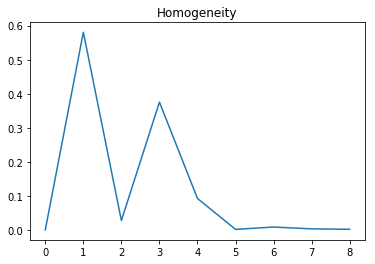

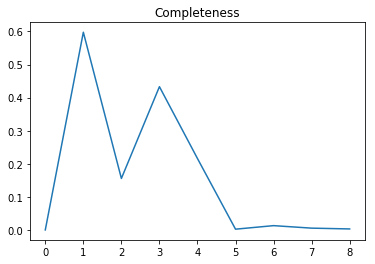

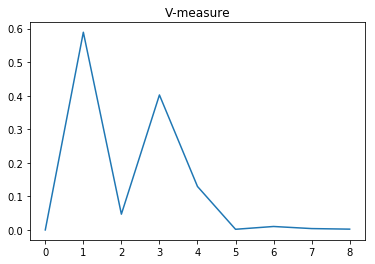

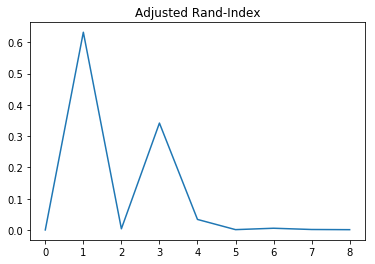

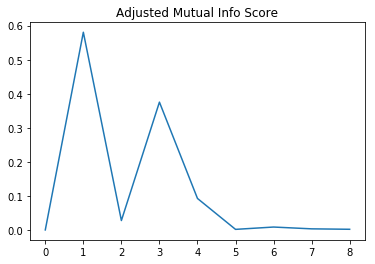

In [80]:
plt.figure();plt.plot(homo);plt.title("Homogeneity")
plt.figure();plt.plot(comp);plt.title("Completeness")
plt.figure();plt.plot(vmea);plt.title("V-measure")
plt.figure();plt.plot(ari);plt.title("Adjusted Rand-Index")
plt.figure();plt.plot(ami);plt.title("Adjusted Mutual Info Score")

plt.show()